# Double pendulum using Lagrange's equation

Uses the DoublePendulum class to generate pendulum plots, show sensitivity to initial conditions, and to simulate the motion of pendulum system. The DoublePendulum class solves the Euler-Lagrange equations using solve_ivp.

* Last Revision 4/28/2023 by Jessy Wu

## Set-Up

We begin by constructing the Langrangian of the double pendulum system. The kinetic and potential energy of the system is given by Taylor Section 11.4. 


$\begin{align}
T = \frac12 (m_1 + m_2)L_1^2 \dot\phi_1^2 + m_2 L_1 L_2 \dot\phi_1 \dot\phi_2 \cos(\phi_1 - \phi_2) \ + \frac12 m_2L_2^2 \dot\phi_2^2
\end{align}$

$\begin{align} 
U = (m_1 + m_2) g L_1 (1 - \cos\phi_1) + m_2 g L_2 ( 1 - \cos\phi_2 )
\end{align}$



## Euler-Lagrange equation

For the double pendulum, the Lagrangian with generalized coordinate $\phi_1$and $\phi_2$ is

$\begin{align}
\mathcal{L} = T - U = \frac12 (m_1 + m_2)L_1^2 \dot\phi_1^2 + m_2 L_1 L_2 \dot\phi_1 \dot\phi_2 \cos(\phi_1 - \phi_2) \ + \frac12 m_2L_2^2 \dot\phi_2^2 - (m_1 + m_2) g L_1 (1 - \cos\phi_1) - m_2 g L_2 ( 1 - \cos\phi_2 )
\end{align}$

The Euler-Lagrange equations are

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_i} - \frac{\partial\mathcal L}{\partial\phi_i} = 0
\end{align}$

For $\phi_1$, we have: \
$\begin{align}
(m_1 + m_2) L_1 \ddot \phi_1 + m_2 L_2 \ddot\phi_2 \cos(\phi_1 - \phi_2) + m_2 L_2 \dot\phi_2^2 \sin(\phi_1 - \phi_2) + (m_1 + m_2) g \sin\phi_1 = 0
  \;.
\end{align}$

For $\phi_2$, we have: \
$\begin{align}
m_2 L_2 \ddot \phi_2 + m_2 L_1 \ddot \phi_1 \cos(\phi_1 - \phi_2) - m_2 L_1 \dot \phi_1^2 \sin(\phi_1-\phi_2) + m_2gsin\phi_2 = 0
\end{align}$
  
Unfortunately, solve_ivp only works for first order differential equations. We can rewrite the Euler-Lagrange equations in a more suitable form by defining a new dependent variable.

We define the following: \
$\begin{align}
z_i = \dot \phi_i \text{ and } \dot z_i = \ddot\phi_i
\end{align}$

After a some algebra, we obtain the following: 

$\begin{align} 
\dot z_1 = \frac{ m_2 g \sin \phi_2 \cos(\phi_1 - \phi_2) - m_2 \sin(\phi_1 - \phi_2)(L_2 z_2^2 + L_1 z_1^2 \cos(\phi_1 - \phi_2)) - (m_1 + m_2) g \sin\phi_1\ } {L_1 (m_1 + m_2 \sin^2(\phi_1 - \phi_2))}
\end{align}$

$\begin{align}
\dot z_2 =  \frac{ -L_1 \dot z_1 \cos(\phi_1 - \phi_2) + L_1 z_1^2 \sin(\phi_1 - \phi_2) - g \sin\phi_2 } {L_2}
\end{align}$



In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [4]:
class DoublePendulum():
    """
    The Double Pendulum class implements the parameters and Lagrange's equations for 
     a simple  double pendulum (no driving or damping).
     
    Parameters
    ----------
    l1 : float
        length of the first pendulum
    l2: float
        length of the second pendulum
    g : float
        gravitational acceleration at the earth's surface
    m1 : float
        mass of first pendulum bob
    m2 : float
        mass of second pendulum bob

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, l1=1., l2=1., m1=1., m2=1., g=1.
                ):
        self.l1 = l1
        self.l2 = l2
        self.g = g
        self.m1 = m1
        self.m2 = m2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq in the vector y. 
        [dphi1/dt dz1/dt dphi2/dt dz2/dt]
    
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi1, y[1] = z1, y[2] = phi2, 
            and y[3] = z2
            
        Returns
        -------
        
        """
        phi1, z1, phi2, z2 = y  
        
        phi1_dot = z1   # What we defined before to get a more suitable form for solve_ode
        phi2_dot = z2
        
        # Our implemented equations from above. 
        
        z1_dot = (self.m2 * self.g * np.sin(phi2) * np.cos(phi1 - phi2) \
                    - self.m2 * np.sin(phi1 - phi2) * (self.l2 * z2**2 + self.l1 * z1**2 * np.cos(phi1 - phi2)) \
                    - (self.m1 + self.m2) * self.g * np.sin(phi1)) \
                    / (self.l1 * (self.m1 + self.m2 * np.sin(phi1 - phi2) **2 ))
        
        z2_dot = (-self.l1 * z1_dot * np.cos(phi1 - phi2) \
                    + self.l1 * z1**2 * np.sin(phi1 - phi2) \
                    - self.g*np.sin(phi2)) / self.l2

        
        return phi1_dot, z1_dot, phi2_dot, z2_dot
    
    def solve_ode(self, t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0, 
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        """
        y = [phi1_0, phi1_dot_0, phi2_0, phi2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi1_dot, phi2, phi2_dot = solution.y

        return phi1, phi1_dot, phi2, phi2_dot

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Double Pendulum plots 

In [7]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')

# Plotting time from t=0 to t=50.
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Set all lengths, masses, and gravity to 1. 

l1 = 1.
l2 = 1.
m1 = 1.
m2 = 1.
g = 1.

# Instantiate a pendulum 
p1 = DoublePendulum(l1=l1, l2=l2, m1=m1, m2=m2, g=g)


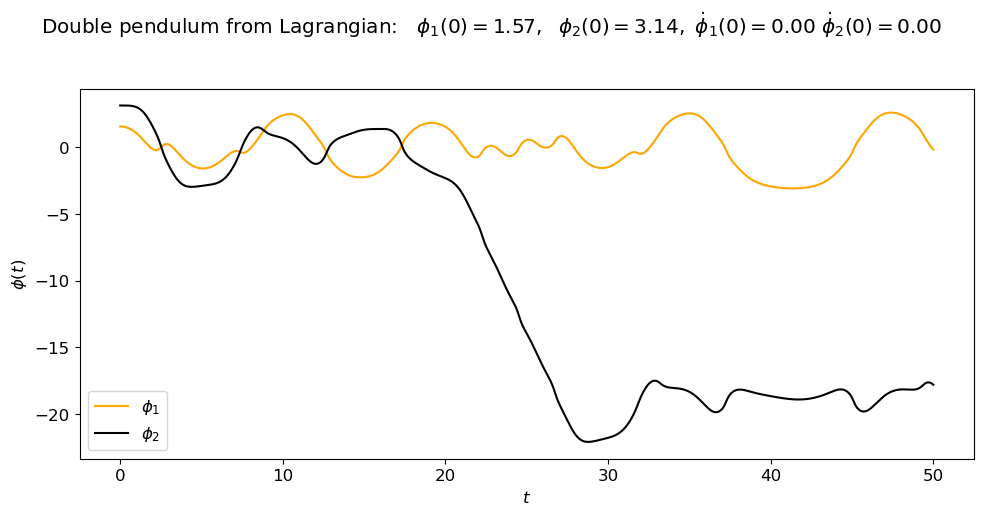

In [30]:
# Establishing initial conditions
phi1_0 = np.pi / 2.
phi1_dot_0 = 0.
phi2_0 = np.pi 
phi2_dot_0 = 0.
phi1, phi1_dot, phi2, phi2_dot = p1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)


# Plotting
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\phi_1(0) = {phi1_0:.2f},$' + \
                rf'  $\phi_2(0) = {phi2_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi1_dot_0:.2f}$' + \
                rf' $\dot\phi_2(0) = {phi2_dot_0:.2f}$'
fig.suptitle(overall_title, va='baseline')
    
# Plot of motion of each bob of double pendulum.
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='orange',
            label=r'$\phi_1$', 
            ax=ax_a)                                               
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            color='black',
            label=r'$\phi_2$', 
            ax=ax_a)

plt.legend(loc='best')
fig.tight_layout()

## Chaos and Sensitivity to Initial Conditions 

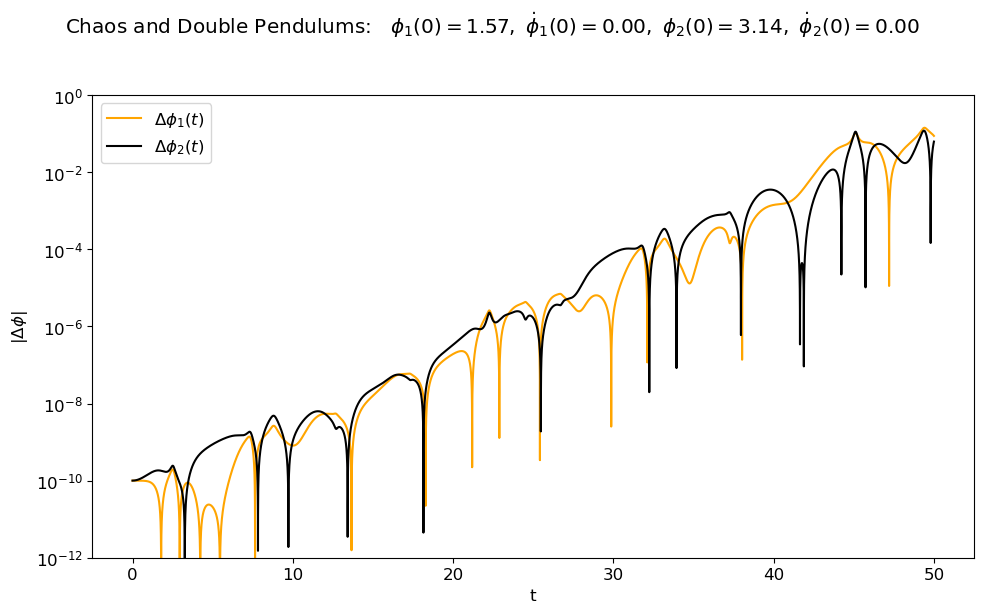

In [27]:
# We will make a plot of delta phi for the same double pendulum but with two slightly different initial conditions
# First Double Pendulum
phi1_0_a = np.pi / 2.
phi1_dot_0_a = 0.
phi2_0_a = np.pi
phi2_dot_0_a = 0.

# Second Double Pendulum
phi1_0_b = phi1_0_a + 1.e-10   # slightly different initial conditions for the second double pendulum
phi1_dot_0_b = 0.
phi2_0_b = np.pi + 1.e-10
phi2_dot_0_b = 0.

phi1a, phi1_dota, phi2a, phi2_dota = \
                                p1.solve_ode(t_pts, phi1_0_a, phi1_dot_0_a, phi2_0_a, phi2_dot_0_a)
phi1b, phi1_dotb, phi2b, phi2_dotb = \
                                p1.solve_ode(t_pts, phi1_0_b, phi1_dot_0_b, phi2_0_b, phi2_dot_0_b)

# Calculate the absolute value of the difference of the two double pendulums
Delta_phi1 = np.fabs(phi1a - phi1b)
Delta_phi2 = np.fabs(phi2a - phi2b)

# Change the common font size
font_size = 12
plt.rcParams.update({'font.size': font_size})

# Plot
fig = plt.figure(figsize=(10, 6))
overall_title = 'Chaos and Double Pendulums:  ' + \
                rf' $\phi_1(0) = {phi1_0_a:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi1_dot_0_a:.2f},$' + \
                rf' $\phi_2(0) = {phi2_0_a:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi2_dot_0_a:.2f}$'
fig.suptitle(overall_title, va='baseline')
    
# A plot from t=0 to t=50. 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, 0., 50.)
ax_a.semilogy(t_pts[start : stop], Delta_phi1[start : stop], 
            color='orange', 
            label=r'$\Delta\phi_1(t)$') 

ax_a.semilogy(t_pts[start : stop], Delta_phi2[start : stop],
            color='black', 
            label=r'$\Delta\phi_2(t)$')

ax_a.set_xlabel('t')
ax_a.set_ylabel(r'$|\Delta\phi|$')
plt.legend(loc='best')

ax_a.set_ylim(1.e-12, 1.)

                              
fig.tight_layout()

As we can see, a very small change in initial conditions leads to an exponential divergence between the two double pendulums. This is an indicator of a chaotic system.